In [28]:
from tensorflow.keras.models import load_model
import joblib
import matplotlib.pyplot as plt

# Load the saved LSTM model
loaded_lstm_model = load_model('../model/lstm_model.h5')
scaler = joblib.load('../model/scaler.pkl')

In [29]:
import yfinance as yf
import pandas as pd

# Fetch TSLA data
tsla_data = yf.download("TSLA", start="2015-01-01", end="2025-01-31")
tsla_data = tsla_data[['Close']]  # Use only the 'Close' price for forecasting
tsla_data.dropna(inplace=True)  # Drop any remaining missing values

[*********************100%***********************]  1 of 1 completed


In [30]:
# Split the data
train_size = int(len(tsla_data) * 0.8)
train, test = tsla_data.iloc[:train_size], tsla_data.iloc[train_size:]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 2028
Testing set size: 507


In [40]:
from sklearn.preprocessing import MinMaxScaler

# Fit the scaler on the training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Close']])

In [41]:
# Scale the test data
test_scaled = scaler.transform(test[['Close']])

In [43]:
import numpy as np

# Use the last 60 days of the test set to predict the next day
last_sequence = test_scaled[-60:].reshape((1, 60, 1))

# Initialize an empty list to store forecasts
forecast_values = []

# Generate forecasts for 6-12 months
forecast_period = 252  # Change to 126 for 6 months
for _ in range(forecast_period):
    next_prediction = loaded_lstm_model.predict(last_sequence)
    forecast_values.append(next_prediction[0, 0])
    
    # Reshape next_prediction to (1, 1, 1) before appending
    next_prediction_reshaped = next_prediction.reshape((1, 1, 1))
    
    # Append the reshaped prediction to last_sequence
    last_sequence = np.append(last_sequence[:, 1:, :], next_prediction_reshaped, axis=1)

# Inverse transform the forecasts to the original scale
forecast_values = scaler.inverse_transform(np.array(forecast_values).reshape(-1, 1))

# Create a date range for the forecast period
import pandas as pd
forecast_dates = pd.date_range(start=test.index[-1], periods=forecast_period+1, freq='B')[1:]  # Business days

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

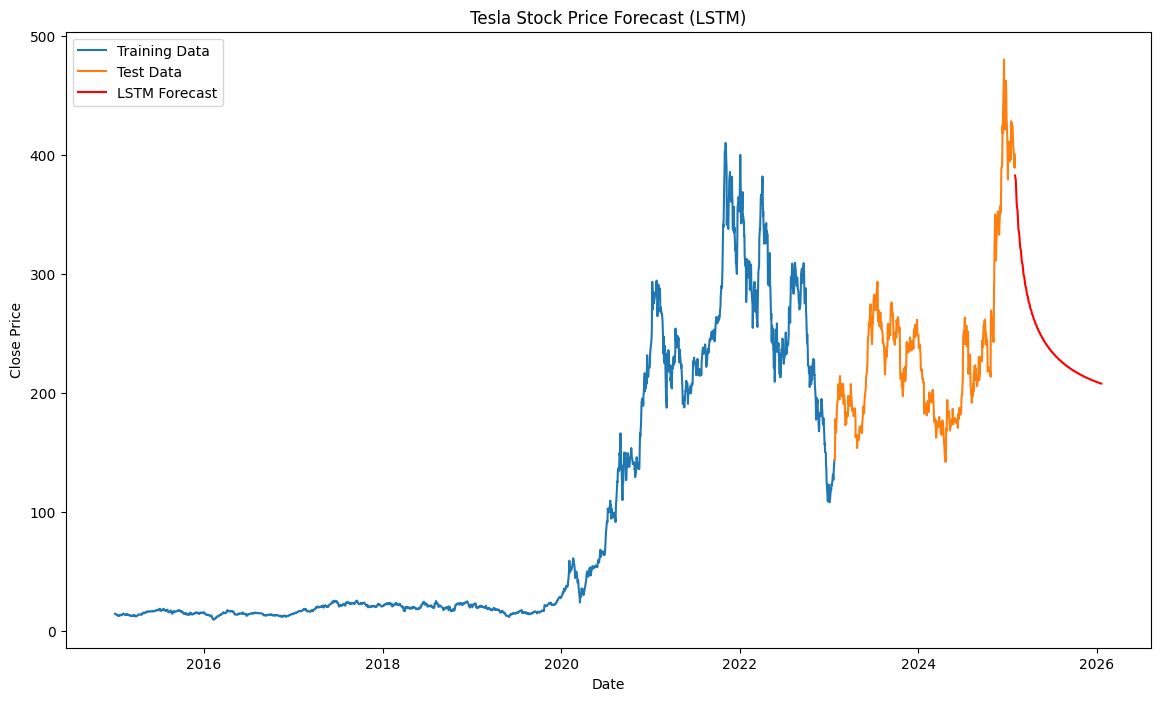

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(forecast_dates, forecast_values, label='LSTM Forecast', color='red')
plt.title('Tesla Stock Price Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()